

# *Covid-19 Face Mask Detection using Deep Neural Networks*



**Dataset** :
Our dataset contains two folders, one having *images* and other having *annotations*.Every image contains multiple people who are either wearing a mask or not wearing it or wearing it incorrectly.

The *annotations* folder contains a file for each image which contains information of each image -it contains information about where the face is in the pic ie the bounding box position ( co-ordinates) and under which category does it fall ie -  wearing a mask or not wearing it or wearing it incorrectly.

**Main Steps** :

*Step 1*:
Go through all the files in the annotations folder and parse the information using beautifulsoup.

*Step 2*:
Next we will use opencv to read the image , extract the face from it, preprocess it and save it to a list.We are going to save the labels simuntaneosly in another list.

*Step 3*:
We will make use the MobilenetV2 as the base model and add some layers on top of it to fine tune it so it performs well for our task.




In [ ]:
#Importing the required libraries

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random as rand
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image
from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import dill

**Step 1 Starts**

In [ ]:
images = list(sorted(os.listdir("/content/drive/MyDrive/FaceMask/images")))
print("Number of images-",len(images))

Number of images- 853


In [ ]:
annotations = list(sorted(os.listdir("/content/drive/MyDrive/FaceMask/annotations")))
print("Number of annotation files-",len(annotations))

Number of annotation files- 853


In [ ]:
# Here we will define the functions that will help us perform Step 1

#This function will get the coordinates of the faces given in the annotations file
# ie the coordinates of lower left corner and upper right corner

def get_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

#This function will help us retrieve the label from the annotation file that is associated with each face and assign them a class 

def get_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0


#In the following function we parse the annotations file and get the objects from them
# Also we will use the above two defined functions here 

def get_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)         #Gives number of faces detected in an image

        boxes = []
        labels = []
        for i in objects:
            boxes.append(get_box(i))    #Saving the boundng box around each face in list boxes
            labels.append(get_label(i)) #Saving the label associated with each face in list labels
            
        boxes=np.array(boxes)
        labels=np.array(labels)
        img_id = np.array(image_id)

    # We save both the list boxes and the list labels in dictionary called target
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [ ]:
#We now call the above defined functions
targets=[]  #Will store the bounding box coordinates of the face and label associated with that face
numobjs=[]  ##Will store number of faces detected in an image

#We need to loop this over the number of images we have ie 853

for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_annotation = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("/content/drive/MyDrive/FaceMask/images", file_image)
    annotation_path = os.path.join("/content/drive/MyDrive/FaceMask/annotations", file_annotation)
    #Using the above defined function called target to get the bounding box around the face and label
    target,numobj = get_target(i, annotation_path)
    targets.append(target)
    numobjs.append(numobj)

**Step 2 Starts**

In [ ]:

face_images=[]  #To store the face extracted from the images
face_labels=[] #To store the corresponding label of the face 
for i in range(853):
    image_path = r"/content/drive/MyDrive/FaceMask/images/maksssksksss{}.png".format(i)
    #read image
    image = cv2.imread(image_path)
    for j in range(numobjs[i]):  # Looping over the bounding boxes of faces in an image
        #Get the bounding box coordinate of the the ith face
        coordinate=(targets[i]['boxes'][j])
        # Now , using the coordinate we extract the face from the image
        #The arguments that are passed to get it are ymin , ymax and xmin,xmax
        img=image[coordinate[1]:coordinate[3],coordinate[0]:coordinate[2]]
        img = cv2.resize(img, (224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        face_images.append(img)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

In [ ]:
print("Number of faces with labels-",len(face_labels))

Number of faces with labels- 4072


In [ ]:
print("The Number of faces belonging to each class")
unique, counts = np.unique(face_labels, return_counts=True)
dict(zip(unique, counts))

The Number of faces belonging to each class


{0: 717, 1: 3232, 2: 123}

In [ ]:
#Only Run this part if you want to save the variables used 
with open("/content/drive/MyDrive/FaceMask/Saved_variables", "wb") as dill_file:
    dill.dump(face_images,dill_file)
    dill.dump(face_labels,dill_file)
    dill.dump(targets,dill_file)
    dill.dump(numobjs,dill_file)

In [ ]:
#Only Run this part if you want to use the previously saved variables
with open("/content/drive/MyDrive/FaceMask/Saved_variables", "rb") as dill_file:
    face_images=dill.load(dill_file)
    face_labels=dill.load(dill_file)
    targets=dill.load(dill_file)
    numobjs=dill.load(dill_file)

In [ ]:
print("Next we will encode the labels")

Next we will encode the labels


In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
#Perform Data augmentation
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

**Step 3 Starts**

In [ ]:
#Let us now define the model
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

#The head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# Placing the head model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
#Defining the hyperparameters for training the neural network
Learning_rate = 1e-4    #Learning rate
Epochs = 120       
Batch_size = 32           #Batch Size

In [ ]:
#Now we divide the data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [ ]:
checkpoint = ModelCheckpoint('FMf2model-{epoch:03d}.model',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')

In [ ]:
#Compiling the model and training it
opt = Adam(lr=Learning_rate, decay=Learning_rate / Epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# Training the head of the network
neural_net = model.fit(
	aug.flow(trainX, trainY, batch_size=Batch_size),
	steps_per_epoch=len(trainX) // Batch_size,
	validation_data=(testX, testY),
	validation_steps=len(testX) // Batch_size,
	epochs=Epochs,
	callbacks=[checkpoint],
class_weight = {0:5 , 1:1, 2:26}) #Here we set the weights to each class. 
#Class having greater weight will be considered more important while training the network

In [ ]:
print("Evaluating the network...")
predIdxs = model.predict(testX, batch_size=32)

# For each image in the test set we need to find the index of the
# label corresponding to the largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Displaying the report of the neural_net
print(classification_report(testY.argmax(axis=1), predIdxs))


# Plotting the training loss and accuracy
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), neural_net.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), neural_net.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), neural_net.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), neural_net.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
#Loading the saved model
import keras
model = keras.models.load_model('/content/drive/MyDrive/FaceMask/model-043.model')

In [ ]:
model.evaluate(testX,testY)

26/26 [==============================] - 1s 44ms/step - loss: 0.2352 - accuracy: 0.9239


[0.23517683148384094, 0.9239263534545898]

In [ ]:
#Code for Taking a pic and feeding it to network  (For Google Colab)

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
#Code for Taking a pic and feeding it to network (For Google Colab)
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

[1.3448171e-03 9.9841356e-01 2.4156434e-04]


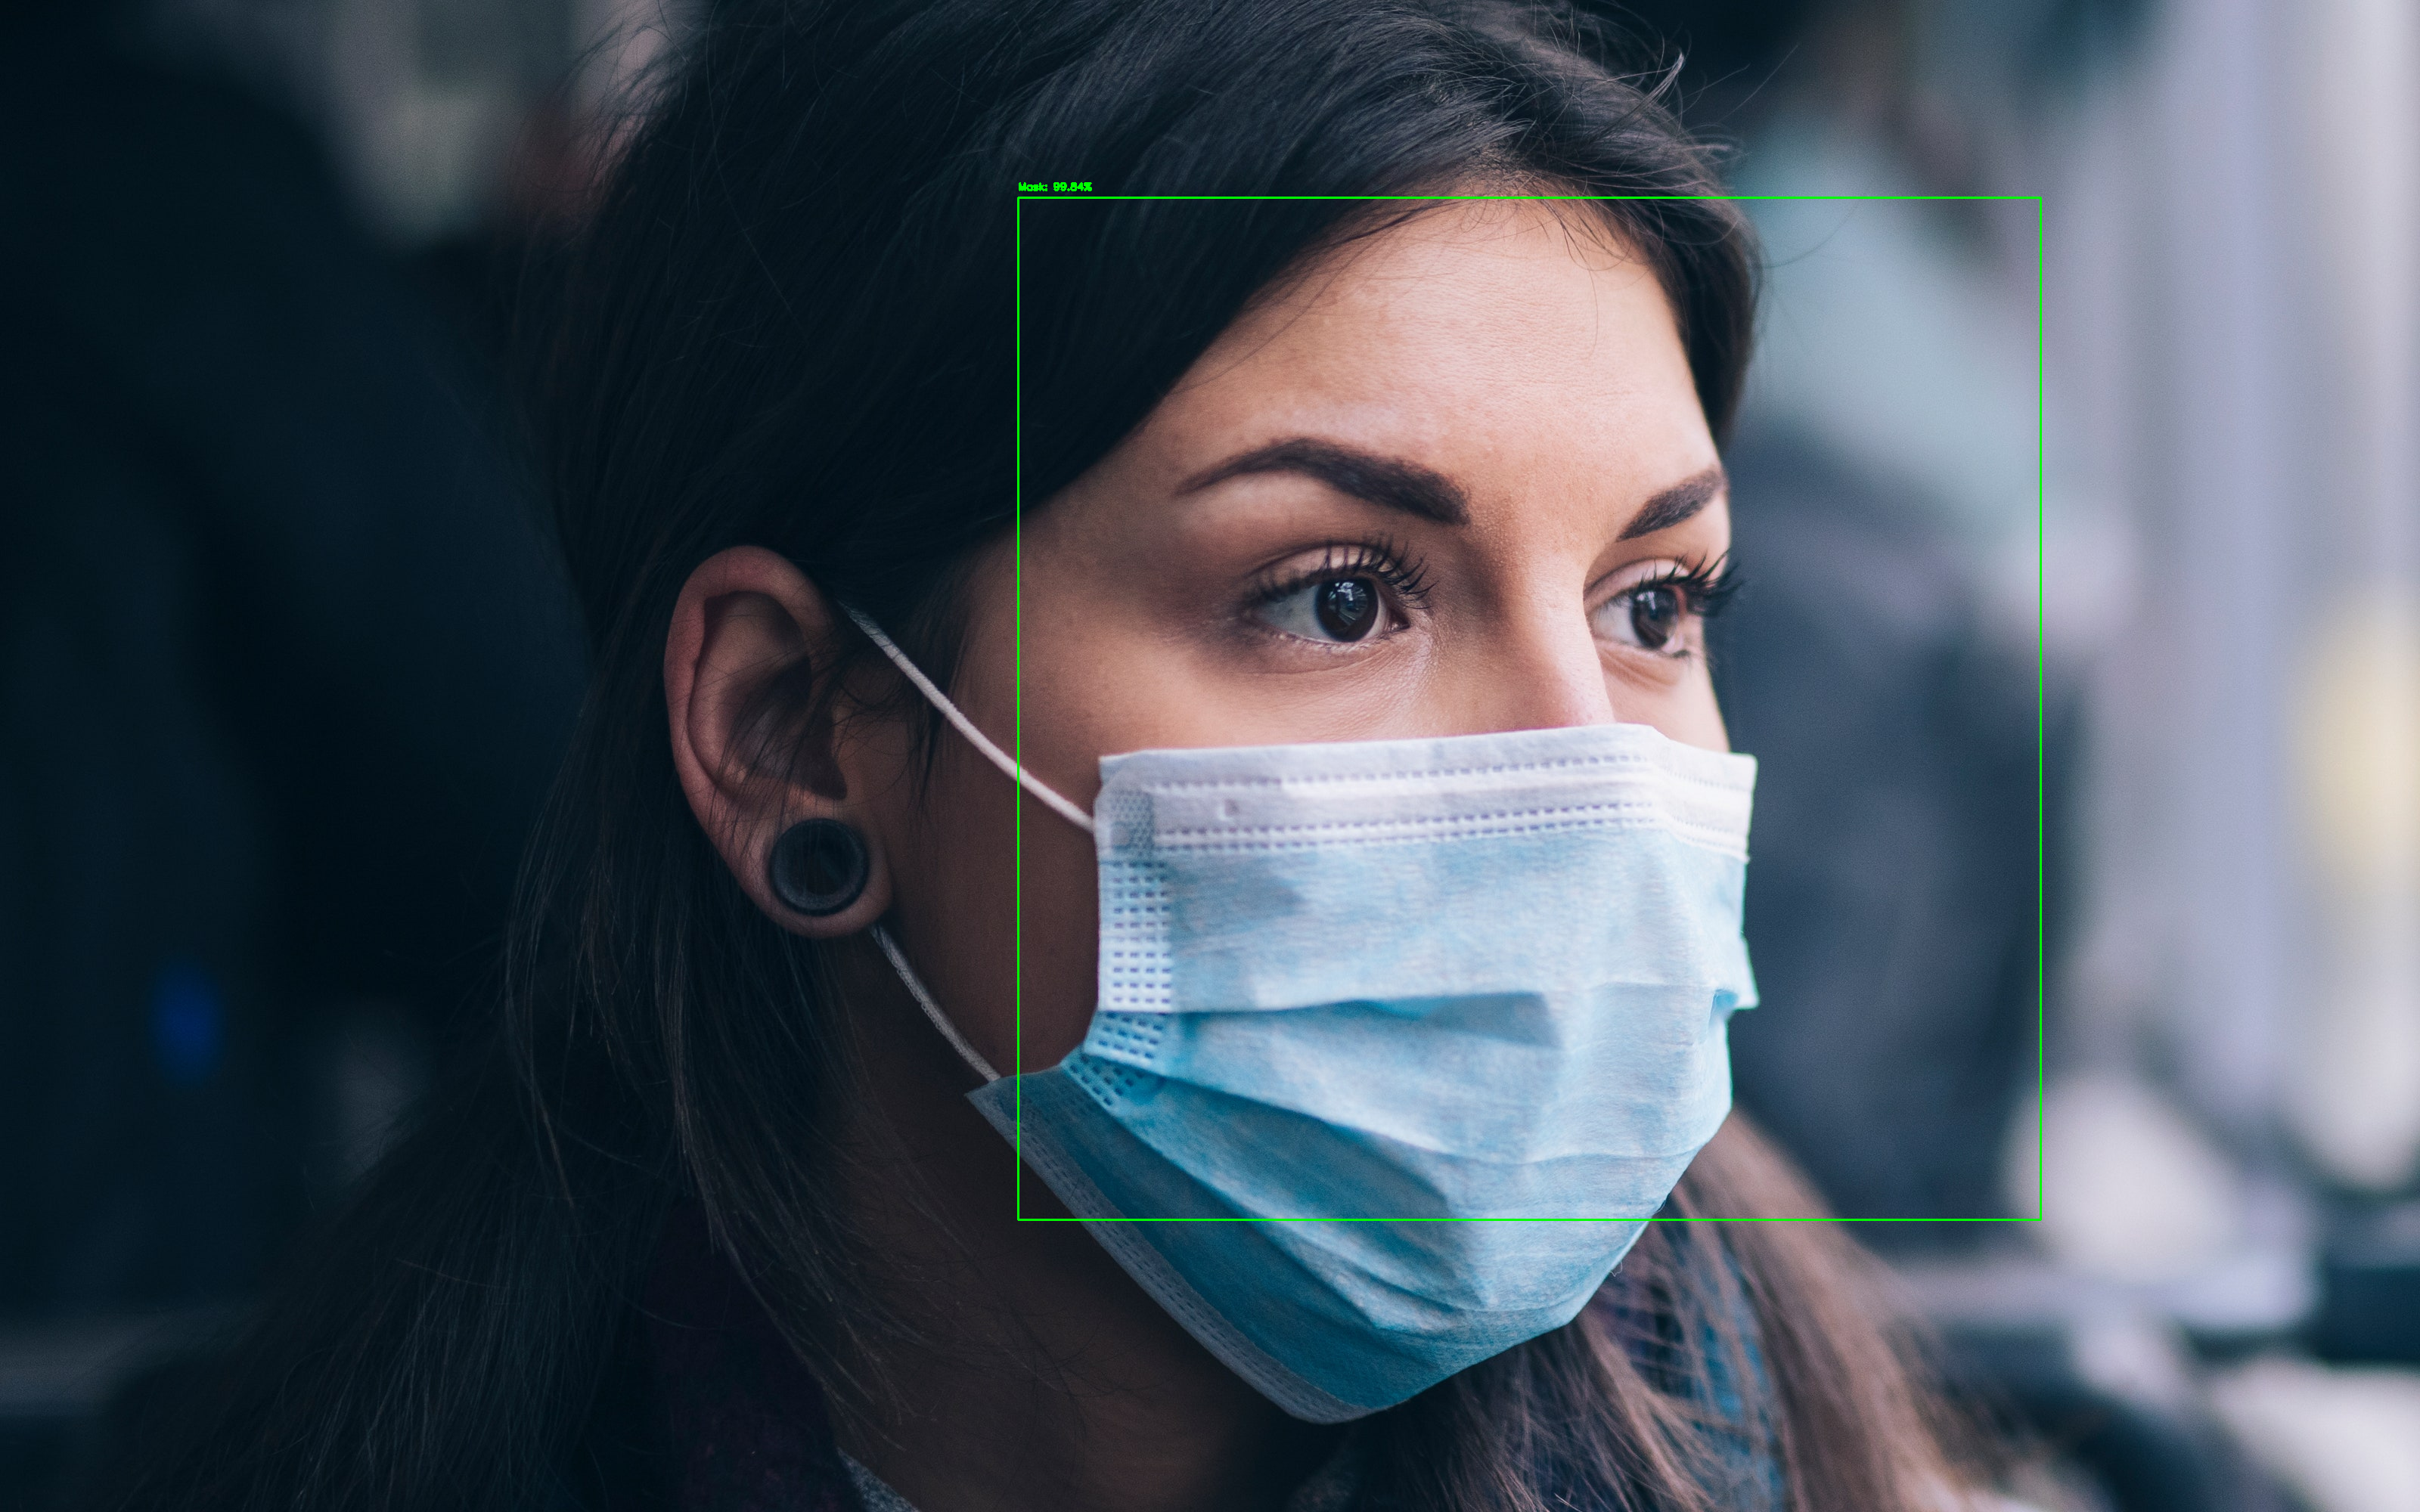

In [ ]:
#Seeing the prediciton of the Network over a pic taken on cam
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
frame=cv2.imread('/content/photo.jpg')
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
faces_list=[]
preds=[]
locs=[]
for (x, y, w, h) in faces:
  face_frame = frame[y:y+h,x:x+w]
  face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
  face_frame = cv2.resize(face_frame, (224, 224))
  face_frame = img_to_array(face_frame)
  face_frame = np.expand_dims(face_frame, axis=0)
  face_frame =  preprocess_input(face_frame)
  faces_list.append(face_frame)
  if len(faces_list)>0:
    (startX, startY, endX, endY) = (x,y,x+w,y+h)
    box=(startX, startY, endX, endY)
    locs.append(box)
    preds = model.predict(face_frame)
    
for (box,pred) in zip(locs,preds):
  (startX, startY, endX, endY) = box
  (mask, withoutMask,notproper) = pred
  print(pred)
    
  # determine the class label and color we'll use to draw
  # the bounding box and text
  if (mask > withoutMask and mask>notproper):
    label = "Without Mask"
  elif ( withoutMask > notproper and withoutMask > mask):
    label = "Mask"
  else:
    label = "Wear Mask Properly"

  if label == "Mask":
    color = (0, 255, 0)
  elif label=="Without Mask":
    color = (0, 0, 255)
  else:
    color = (255, 140, 0)

        # include the probability in the label
  label = "{}: {:.2f}%".format(label,
                                     max(mask, withoutMask, notproper) * 100)

        # display the label and bounding box rectangle on the output
        # frame
  cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    
    
  # Display the resulting frame
cv2_imshow(frame)